# Supervised RPM on EMG features

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap

from sklearn.decomposition import KernelPCA

import torch
import torch.nn as nn
import torch.distributions as torch_dist

from lift.datasets import load_all_mad_datasets, compute_features, mad_labels_to_actions, mad_groupby_labels
from configs import BaseConfig

In [128]:
class Interpolator:
    def __init__(self, features_group, actions_group, k=None):
        """
        features_group (torch.tensor): size=[num_samples, num_labels, feature_dim]
        actions_group (torch.tensor): size=[num_samples, num_labels, act_dim]
        """
        self.features = features_group
        self.actions = actions_group
        self.epsilon = 1e-5
        self.k = k

    def __call__(self, new_actions):
        if not isinstance(new_actions, torch.Tensor):
            new_actions = torch.tensor(new_actions, dtype=torch.float32)

        # Step 0: sample features and actions to interpolate
        # idx_sample = torch.randint(0, len(self.features), size=(len(new_actions),))
        # base_features = self.features[idx_sample]
        # base_actions = self.actions[idx_sample]
        
        # Step 1: Calculate distances for each new action
        # This results in a (batch_size, num_samples) distance matrix
        distances = torch.norm(self.actions - new_actions[:, None, :], dim=2)
        # distances = torch.norm(base_actions - new_actions.unsqueeze(-2), dim=-1)

        # Step 2: Compute interpolation weights
        weights = 1 / (distances + self.epsilon)
        weights /= weights.sum(axis=1, keepdims=True)

        # Step 4: select k elements of the weights, set rest to 0
        if self.k is not None:
            indices = torch.multinomial(weights, self.k, replacement=False)
            mask = torch.zeros_like(weights)
            mask.scatter_(1, indices, 1)

            sampled_weights = weights * mask
            sampled_weights /= sampled_weights.sum(dim=1, keepdim=True)

            weights = sampled_weights

        # Step 3: Interpolate features
        interpolated_features_batch = torch.tensordot(weights, self.features, dims=([1],[0]))
        # interpolated_features_batch = torch.sum(weights.unsqueeze(-1) * base_features, dim=-2)
        return interpolated_features_batch
    
def normalize(x, mu, std):
    return (x - mu) / std

In [168]:
torch.manual_seed(0)

config = BaseConfig()
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)

# subsample window
num_samples_per_group = 1
mad_windows_group, mad_labels_group = mad_groupby_labels(mad_windows, mad_labels)
sample_idx = [torch.randint(0, len(g), size=(num_samples_per_group,)) for g in mad_windows_group]
mad_windows_group = [g[sample_idx[i]] for i, g in enumerate(mad_windows_group)]
mad_labels_group = [l * torch.ones_like(sample_idx[l]) for l in mad_labels_group]

mad_actions_group = [mad_labels_to_actions(
        g, recording_strength=config.simulator.recording_strength,
) for g in mad_labels_group]
mad_features_group = [compute_features(g, feature_list = ['MAV']) for g in mad_windows_group]

mad_features_group = torch.cat(mad_features_group, dim=0)
mad_actions_group = torch.cat(mad_actions_group, dim=0)

act_dim = mad_actions_group[0].shape[-1]

In [169]:
interpolator = Interpolator(mad_features_group, mad_actions_group, k=None)

sample_actions = torch.rand(10_000, 3) * 2 - 1
sample_features = interpolator(sample_actions)

sample_features_norm = normalize(sample_features, sample_features.mean(0), sample_features.std(0))

## Try PCA

In [170]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean", 
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(sample_features_norm)

In [190]:
pca = KernelPCA(n_components=3).fit(sample_features_norm.numpy())
pca_pred = pca.transform(sample_features_norm.numpy())

In [172]:
def scatter_plot_embeddings(embeddings, c, title, ax, cmap="coolwarm", vmin=-1., vmax=1., s=4):
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=c, cmap=cmap, vmin=vmin, vmax=vmax, s=4)
    ax.set_title(title)
    return ax

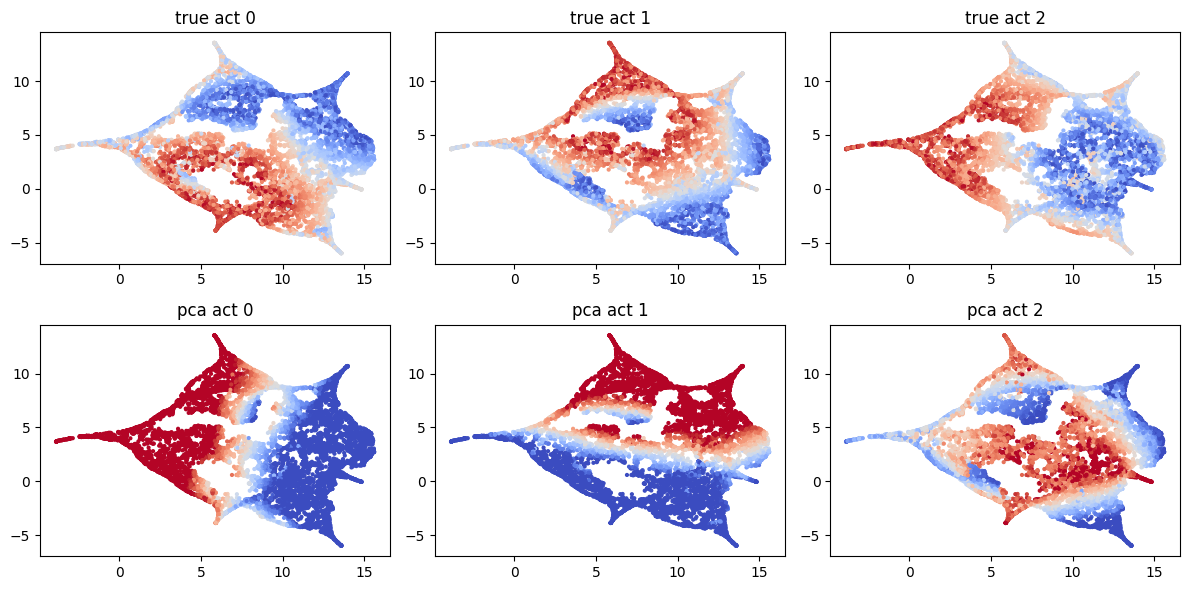

In [192]:
# visualize
fig, ax = plt.subplots(2, act_dim, figsize=(4 * act_dim, 6))
for i in range(act_dim):
    scatter_plot_embeddings(embeddings, sample_actions[:, i], f"true act {i}", ax[0, i])
    scatter_plot_embeddings(embeddings, pca_pred[:, i], f"pca act {i}", ax[1, i])
plt.tight_layout()
plt.show()

## RPM

In [30]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        out = self.network(x)
        return out
    
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim * 2, hidden_dims)
    
    def forward(self, x):
        mu, ls = torch.chunk(self.mlp(x), 2, dim=-1)
        sd = ls.exp()
        return mu, sd
    
    def encode(self, x):
        mu, sd = self.forward(x)
        return torch_dist.Normal(mu, sd)
    
class RPMCont(nn.Module):
    """Continuous recognition parameterized model"""
    def __init__(self, x_dim, z_dim, y_dim, hidden_dims, energy_func="f", beta_1=1., beta_2=0.3, beta_3=0.2, beta_4=0.):
        super().__init__()
        self.energy_func = energy_func
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.beta_3 = beta_3
        self.beta_4 = beta_4

        if energy_func == "f":
            self.f = MLP(x_dim + z_dim, 1, hidden_dims)
        elif energy_func == "logp":
            self.f = GaussianEncoder(x_dim, z_dim, hidden_dims)
        
        self.encoder = GaussianEncoder(x_dim, z_dim, hidden_dims)
        self.linear = nn.Linear(z_dim, y_dim)
    
    def forward_f(self, x, z):
        f = self.f(torch.cat([x, z], dim=-1))

        sample_idx_neg = torch.randint(len(x), size=(50,)) # hard code number of negative samples
        x_neg = x[sample_idx_neg]
        x_neg_ = x_neg.unsqueeze(0).repeat_interleave(len(x), dim=0)
        z_ = z.unsqueeze(1).repeat_interleave(len(x_neg), dim=1)
        f_neg_ = self.f(torch.cat([x_neg_, z_], dim=-1))
        f_neg_ = torch.cat([f.unsqueeze(-2), f_neg_], dim=-2)
        
        # lse = torch.logsumexp(f_neg_, dim=-2)
        # logp = f - lse

        labels = torch.zeros_like(f_neg_.squeeze(-1))
        labels[:, 0] = 1
        p = torch.softmax(f_neg_.squeeze(-1), dim=-1)
        logp = -cross_entropy(labels, p)
        accuracy = torch.sum(p.argmax(-1) == labels.argmax(-1)) / len(p)        
        return logp, accuracy
    
    def forward_logp(self, x, z):
        z_dist = self.f.encode(x)

        # f = z_dist.log_prob(z).sum(-1)
        f_neg = z_dist.log_prob(z.unsqueeze(-2)).sum(-1)
        
        # lse = torch.logsumexp(f_neg, dim=-1)
        # logp = f - lse

        labels = torch.eye(len(x))
        p = torch.softmax(f_neg, dim=-1)
        logp = -cross_entropy(labels, p)
        accuracy = torch.sum(p.argmax(-1) == labels.argmax(-1)) / len(p)        
        return logp, accuracy
    
    def forward(self, x, z):
        """Compute log likelihood up to a constant for a batch"""
        if self.energy_func == "f":
            logp = self.forward_f(x, z)
        elif self.energy_func == "logp":
            logp = self.forward_logp(x, z)
        return logp
    
    def encode(self, x):
        mu, sd = self.encoder.forward(x)
        post = torch_dist.Normal(mu, sd)
        return post
    
    def compute_cov(self, z):
        """Compute representation covariance"""
        z_mean = z.mean(0, keepdim=True)
        z_res = z - z_mean
        cov = torch.sum(z_res.unsqueeze(-2) * z_res.unsqueeze(-1), dim=0) / (len(z_res) - 1)
        return cov
    
    def compute_cov_loss(self, cov):
        mask = (1 - torch.eye(len(cov)))
        loss = torch.sum(cov.abs() * mask) / mask.sum()
        return loss
    
    def compute_loss(self, x, y):
        """ELBO loss"""
        # e step
        post = self.encode(x)
        z = post.rsample()
        ent = post.entropy().sum(-1)
        
        # m step
        log_prior = torch_dist.Normal(torch.zeros(1), torch.ones(1)).log_prob(z).sum(-1)
        logp, accuracy = self.forward(x, z)
        loss = logp.mean() + self.beta_1 * log_prior.mean() + self.beta_2 * ent.mean()

        # reg
        cov = self.compute_cov(z)
        cov_loss = self.compute_cov_loss(cov)
        loss -= self.beta_3 * cov_loss

        # supervised loss
        pred = z
        clf_loss = -torch.pow(pred - y, 2).mean()
        loss += self.beta_4 * clf_loss

        stats = {
            "loss": -loss.data.mean().item(),
            "accuracy": accuracy.data.item(),
            "log_like_y": clf_loss.data.item(),
            "log_like": logp.data.mean().item(),
            "log_prior": log_prior.data.mean().item(),
            "ent": ent.data.mean().item(),
            "cov": cov_loss.data.item(),
        }
        return -loss, stats

In [47]:
def print_grads(model):
    for n, p in model.named_parameters():
        if p.grad is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

def train(model, loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        epoch_stats = []
        for batch in loader:
            data = {"x": batch[0], "y": batch[1]}
            loss, stats = model.compute_loss(**data)

            optimizer.zero_grad()
            loss.backward()
            # print_grads(model)
            optimizer.step()

            epoch_stats.append(stats)
        epoch_stats = pd.DataFrame(epoch_stats).mean().to_dict()

        bar.set_description(f"e: {e}, loss: {epoch_stats['loss']:.2f}")
        history.append(epoch_stats)
    history = pd.DataFrame(history)
    return model, history

In [178]:
# train test split
dataset = torch.utils.data.TensorDataset(sample_features_norm, sample_actions)
loader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=True)

In [179]:
# train without supervision
torch.manual_seed(0)

x_dim = sample_features_norm.shape[-1]
z_dim = 3
y_dim = sample_actions.shape[-1]
hidden_dims = [200, 200]
rpm = RPMCont(
    x_dim, 
    z_dim, 
    y_dim,
    hidden_dims, 
    energy_func="f",
    beta_1=0.2,
    beta_2=0.2,
    beta_3=0.2,
    beta_4=0.,
)

lr = 1.e-3
epochs = 100
rpm, df_history = train(rpm, loader, epochs, lr)

e: 99, loss: 1.40: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


In [180]:
# train without supervision
torch.manual_seed(0)

x_dim = sample_features_norm.shape[-1]
z_dim = 3
y_dim = sample_actions.shape[-1]
hidden_dims = [200, 200]
s_rpm = RPMCont(
    x_dim, 
    z_dim, 
    y_dim,
    hidden_dims, 
    energy_func="f",
    beta_1=0.2,
    beta_2=0.2,
    beta_3=0.2,
    beta_4=3.,
)

lr = 1.e-3
epochs = 100
s_rpm, df_history_s = train(s_rpm, loader, epochs, lr)

e: 99, loss: 1.67: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


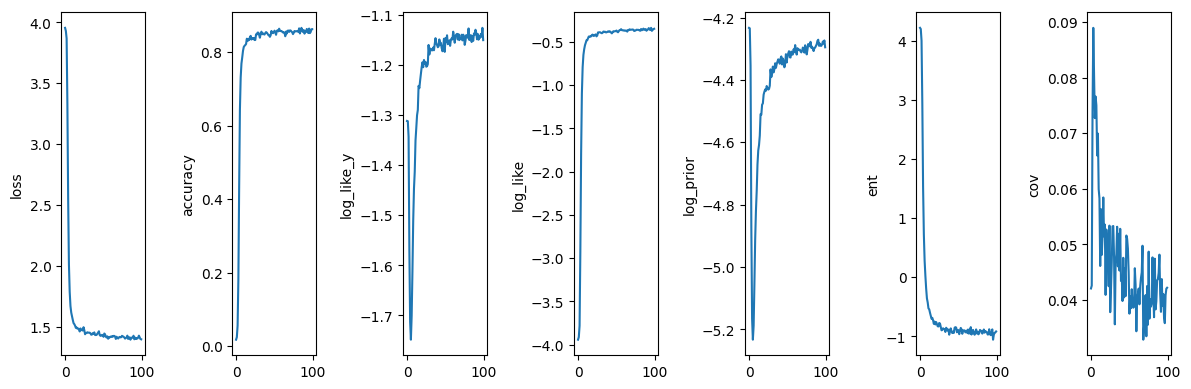

In [182]:
loss_keys = list(df_history.columns)
fig, ax = plt.subplots(1, len(loss_keys), figsize=(12, 4))
for i, k in enumerate(loss_keys):
    ax[i].plot(df_history[k])
    ax[i].set_label("epoch")
    ax[i].set_ylabel(k)
plt.tight_layout()
plt.show()

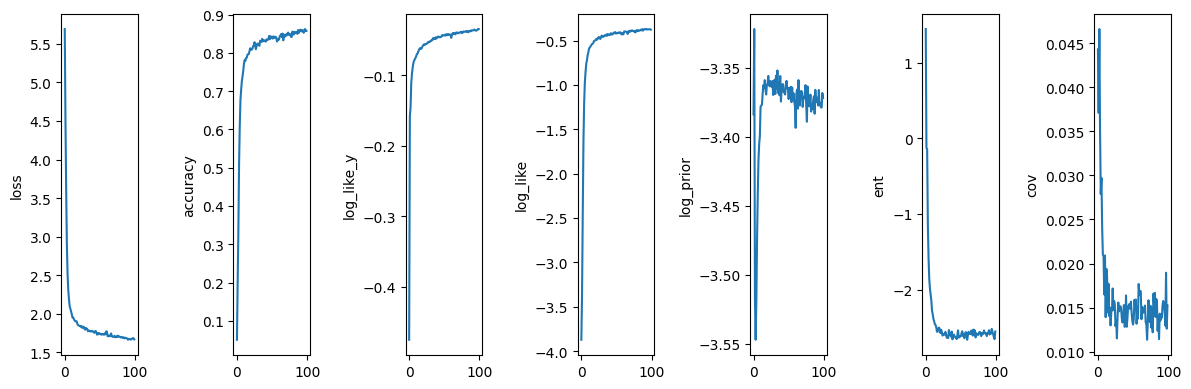

In [183]:
loss_keys = list(df_history.columns)
fig, ax = plt.subplots(1, len(loss_keys), figsize=(12, 4))
for i, k in enumerate(loss_keys):
    ax[i].plot(df_history_s[k])
    ax[i].set_label("epoch")
    ax[i].set_ylabel(k)
plt.tight_layout()
plt.show()

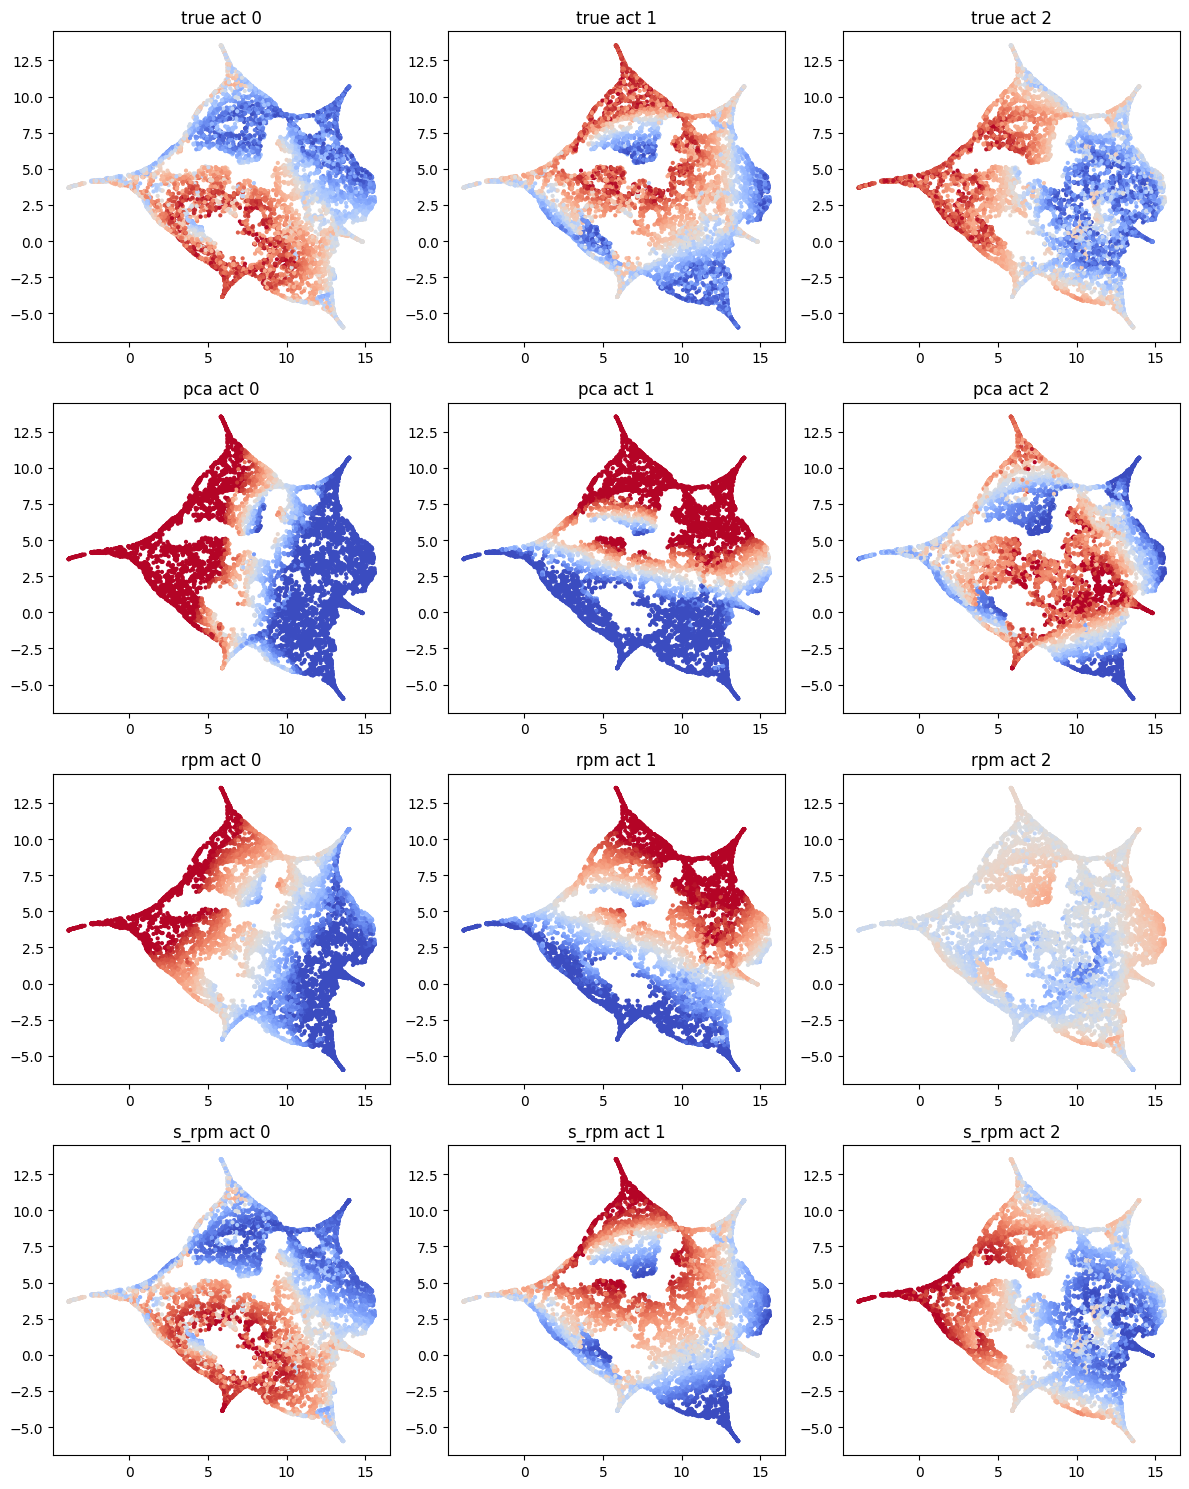

In [185]:
# visualize
with torch.no_grad():
    rpm_pred = rpm.encode(sample_features_norm).mean
    srpm_pred = s_rpm.encode(sample_features_norm).mean

fig, ax = plt.subplots(4, act_dim, figsize=(4 * act_dim, 15))
for i in range(act_dim): 
    scatter_plot_embeddings(embeddings, sample_actions[:, i], f"true act {i}", ax[0, i])
    scatter_plot_embeddings(embeddings, pca_pred[:, i], f"pca act {i}", ax[1, i])
    scatter_plot_embeddings(embeddings, rpm_pred[:, i], f"rpm act {i}", ax[2, i])
    scatter_plot_embeddings(embeddings, srpm_pred[:, i], f"s_rpm act {i}", ax[3, i])
plt.tight_layout()
plt.show()